In [2]:
from scipy.stats import f_oneway
from scipy.stats import kruskal

import pandas as pd
import numpy as np
import tellurium as te

import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os

import gzip
import cloudpickle

In [3]:
os.chdir('..')
from src import util
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Visualizing Spearman data 

### Condense Spearman data

In [4]:
os.chdir('../data/results/spearman_coefficients/')

In [5]:
spr_file_list = [i for i in os.listdir() if "topologyB" in i]

spr_dfs = []
for file in spr_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    spr_dfs.append(a)

all_spr_df_B = pd.concat(spr_dfs)
all_spr_df_B

,Unnamed: 0,r,p-value,lower,upper,reg,omit
0,0.1x,0.484004,4.182552e-02,-0.092135,0.838135,noReg,allData
1,0.2x,0.657379,3.030290e-03,0.168797,0.937539,noReg,allData
2,0.3x,0.306502,2.160638e-01,-0.237584,0.737300,noReg,allData
3,0.4x,0.471620,4.816898e-02,-0.067065,0.848249,noReg,allData
4,0.5x,0.890609,7.277474e-07,0.694355,0.964691,noReg,allData
...,...,...,...,...,...,...,...
5,1.5x,0.446852,6.301029e-02,-0.079369,0.786484,reg2,omitIntMet
6,3x,0.655315,3.155847e-03,0.243691,0.911123,reg2,omitIntMet
7,5x,0.259030,2.993048e-01,-0.321590,0.723278,reg2,omitIntMet
8,7x,0.657379,3.030290e-03,0.204200,0.890782,reg2,omitIntMet


In [6]:
os.chdir('../../../notebooks/')

In [7]:
all_spr_df_B.rename(columns={'Unnamed: 0':'perturbation'}, inplace=True)
all_spr_df_B['perturbation'] = [float(i.split('x')[0]) for i in all_spr_df_B['perturbation']]

In [8]:
all_spr_df_B = all_spr_df_B[all_spr_df_B['perturbation'] != 1.01]

In [9]:
b = all_spr_df_B.pivot(index=['omit', 'reg'], columns='perturbation', values='r')
b

perturbation           0.1       0.2       0.3       0.4       0.5       1.5   \
omit        reg                                                                 
allData     noReg  0.484004  0.657379  0.306502  0.471620  0.890609  0.628483   
            reg1   0.172343  0.653251  0.438596  0.653251  0.700722  0.405573   
            reg2   0.211558  0.719298  0.424149  0.704850  0.754386  0.471620   
omitEnzymes noReg  0.504644  0.318885  0.159959  0.659443  0.752322  0.510836   
            reg1   0.479876  0.420021  0.727554  0.797730  0.847265  0.624355   
            reg2   0.498452  0.298246  0.647059  0.917441  0.886481  0.626419   
omitExMet   noReg  0.318885  0.341589  0.768834  0.533540  0.892673  0.566563   
            reg1   0.362229  0.521156  0.708978  0.754386  0.808050  0.403509   
            reg2   0.205366  0.585139  0.669763  0.723426  0.729618  0.496388   
omitFluxes  noReg -0.110423  0.007224  0.228070  0.417957  0.025800  0.263158   
            reg1  -0.007224  0.335397  0.294118  0.118679 -0.056760  0.013416   
            reg2   0.155831  0.027864  0.230134 -0.052632 -0.098039  0.469556   
omitIntMet  noReg  0.349845  0.106295  0.128999  0.256966  0.075335  0.514964   
            reg1   0.289990  0.091847  0.252838  0.277606  0.351909  0.347781   
            reg2  -0.009288  0.265222  0.102167  0.168215 -0.246646  0.446852   

perturbation           3.0       5.0       7.0       10.0  
omit        reg                                            
allData     noReg  0.310630  0.358101  0.405573  0.426213  
            reg1   0.302374  0.537668  0.506708  0.502580  
            reg2   0.510836  0.122807  0.560372  0.440660  
omitEnzymes noReg  0.403509  0.576883  0.331269  0.552116  
            reg1   0.444788  0.498452  0.634675  0.407637  
            reg2   0.500516  0.504644  0.254902  0.628483  
omitExMet   noReg  0.298246  0.318885  0.368421  0.382869  
            reg1   0.285862  0.481940  0.550052  0.473684  
            reg2   0.318885  0.609907  0.374613  0.539732  
omitFluxes  noReg  0.430341  0.347781  0.215686  0.304438  
            reg1   0.333333  0.246646  0.034056  0.426213  
            reg2   0.450980  0.574819  0.071207  0.477812  
omitIntMet  noReg  0.209494  0.351909  0.325077  0.285862  
            reg1   0.046440  0.432405  0.632611  0.380805  
            reg2   0.655315  0.259030  0.657379  0.533540

In [10]:
fluxes_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitFluxes']))]
enzymes_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitEnzymes']))]
intMet_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitIntMet']))]
exMet_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitExMet']))]

### All-in-one scatter plots

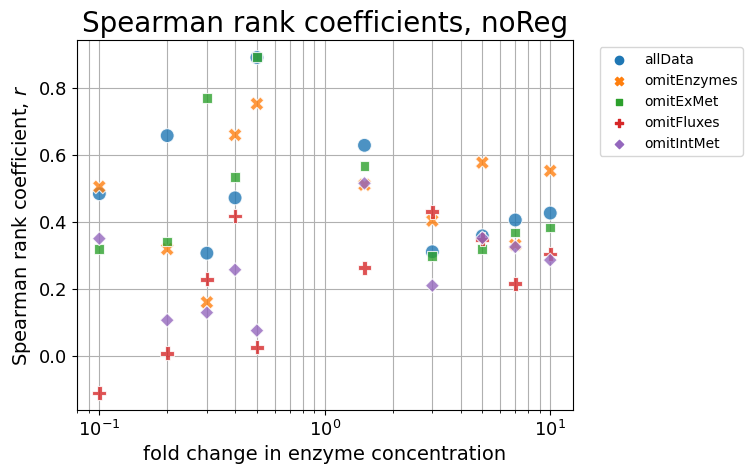

In [11]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='noReg')], 'Spearman rank coefficients, noReg')

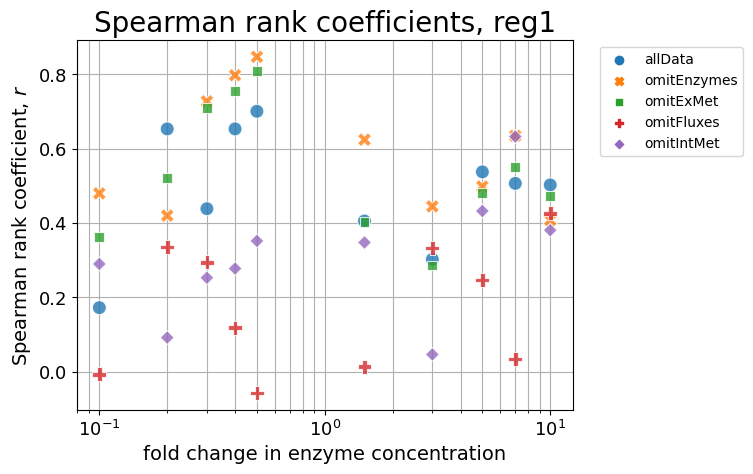

In [12]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg1')], 'Spearman rank coefficients, reg1')

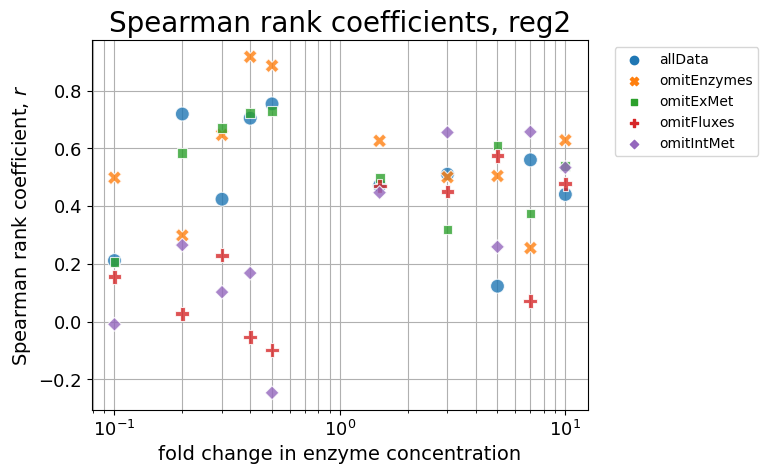

In [13]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2')], 'Spearman rank coefficients, reg2')

## Visualizing MAE across the different types of data

In [14]:
os.chdir('../data/results/MAE/')
MAE_file_list = [i for i in os.listdir() if "topologyB" in i]

MAE_dfs = []
for file in MAE_file_list:
    b = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    b['reg'] = [reg]*len(b)
    b['omit'] = [omit]*len(b)
    MAE_dfs.append(b)

all_MAE_df_B = pd.concat(MAE_dfs)
all_MAE_df_B

os.chdir('../../../notebooks/')


In [15]:
all_MAE_df_B.columns = ['perturbation', 'values', 'reg', 'omit']
all_MAE_df_B['values'] = all_MAE_df_B['values']/247
all_MAE_df_B

,perturbation,values,reg,omit
0,gt,0.000000,noReg,allData
1,0.1x,0.254254,noReg,allData
2,0.2x,0.251754,noReg,allData
3,0.3x,0.233770,noReg,allData
4,0.4x,0.236062,noReg,allData
...,...,...,...,...
6,1.5x,0.509998,reg2,omitIntMet
7,3x,0.508032,reg2,omitIntMet
8,5x,0.515365,reg2,omitIntMet
9,7x,0.525564,reg2,omitIntMet


In [16]:
# a = all_MAE_df_B.pivot(index=['omit', 'reg'], columns='perturbation', values='values')

all_MAE_df_B = all_MAE_df_B[all_MAE_df_B['perturbation'] != 1.01]
all_MAE_df_B = all_MAE_df_B[all_MAE_df_B['perturbation'] != 'knockout']


C:\Users\user\AppData\Local\Temp\ipykernel_10300\2885349465.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, B-noReg')

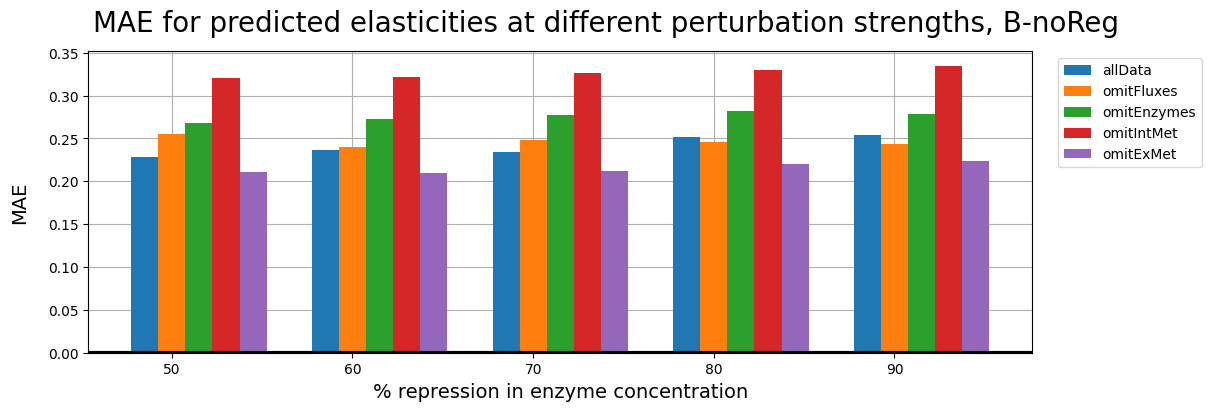

In [17]:
noReg_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'noReg']
noReg_df['r'] = noReg_df['values'].round(3)
noReg_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)

ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, B-noReg", size=20)


C:\Users\user\AppData\Local\Temp\ipykernel_10300\1654470176.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, B-reg1')

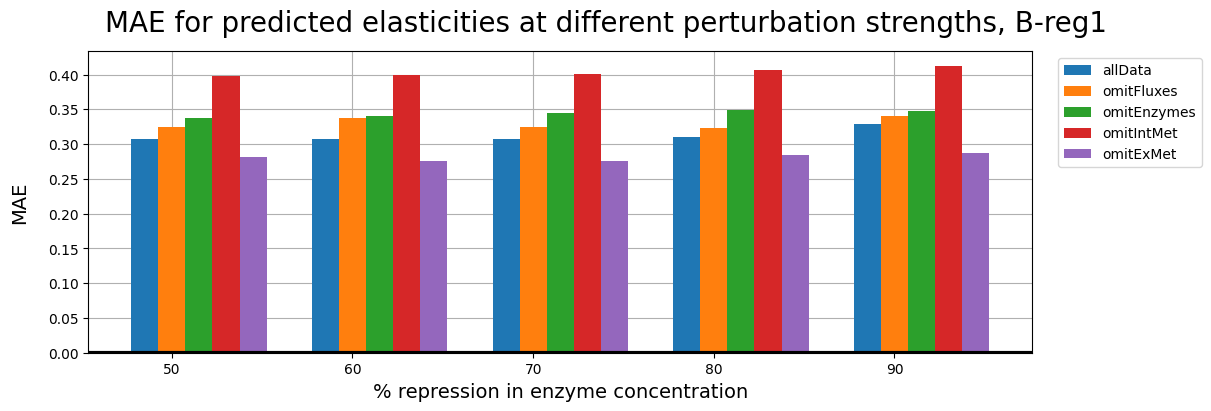

In [18]:
reg1_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'reg1']
reg1_df['r'] = reg1_df['values'].round(3)
reg1_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((reg1_df[reg1_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((reg1_df[reg1_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((reg1_df[reg1_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((reg1_df[reg1_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((reg1_df[reg1_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)

ax.set_xticks(x + width, ['50','60','70','80','90'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, B-reg1", size=20)


C:\Users\user\AppData\Local\Temp\ipykernel_10300\3502383712.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, B-reg2')

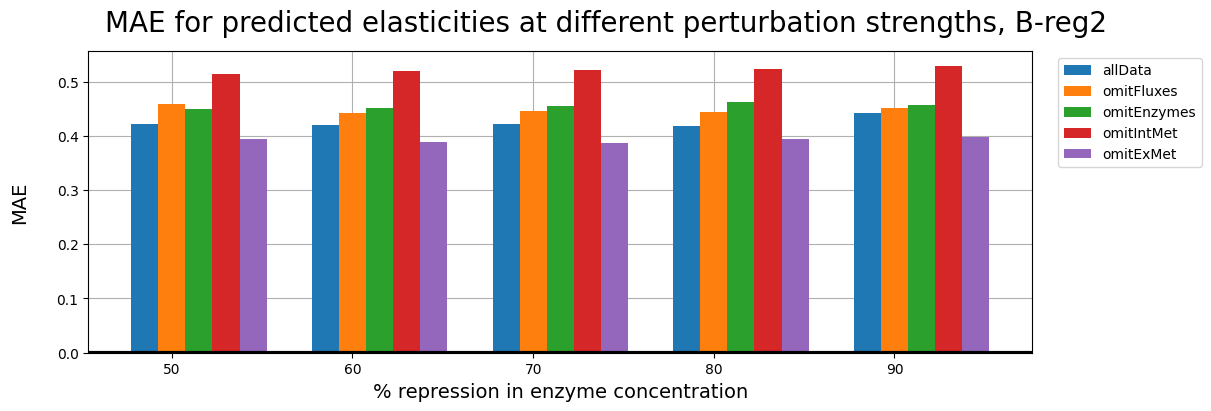

In [19]:
reg2_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'reg2']
reg2_df['r'] = reg2_df['values'].round(3)
reg2_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((reg2_df[reg2_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((reg2_df[reg2_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((reg2_df[reg2_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((reg2_df[reg2_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((reg2_df[reg2_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['50','60','70','80','90'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, B-reg2", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, B-noReg')

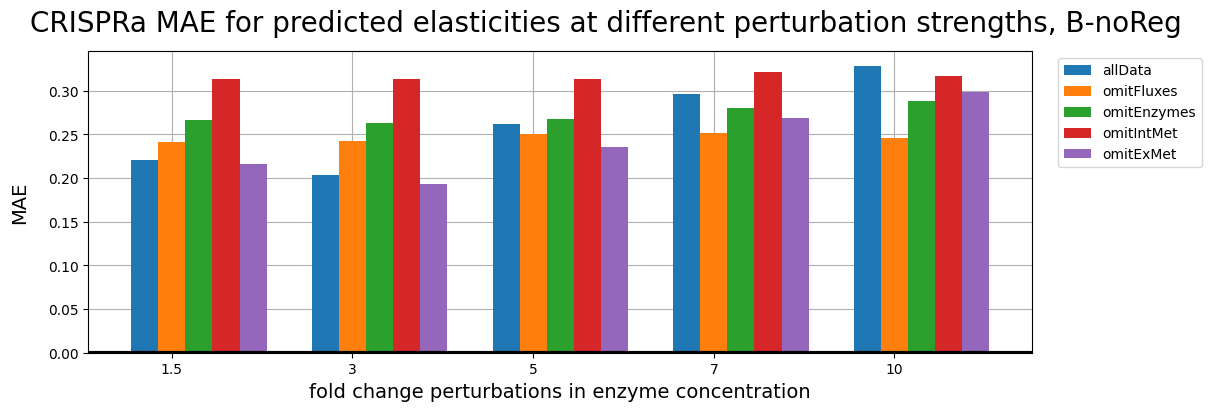

In [20]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, B-noReg", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, B-reg1')

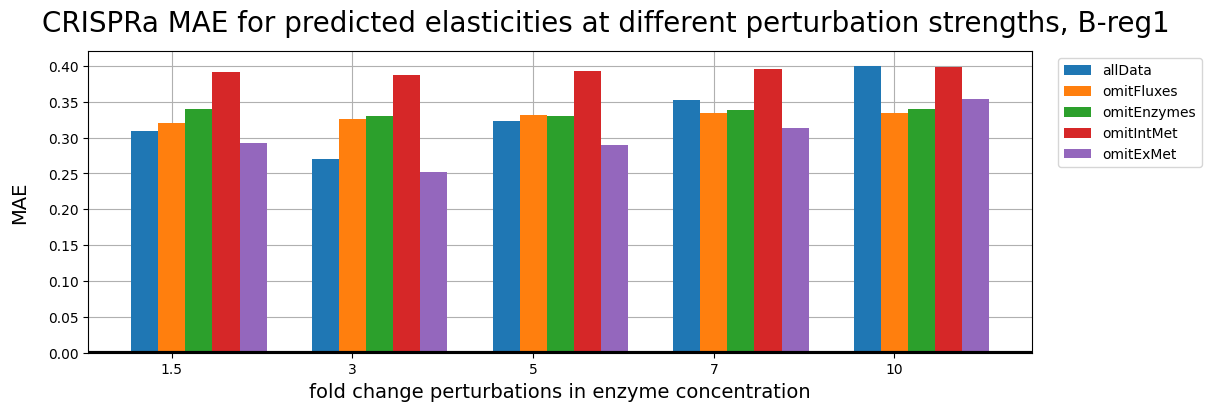

In [21]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((reg1_df[reg1_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((reg1_df[reg1_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((reg1_df[reg1_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((reg1_df[reg1_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((reg1_df[reg1_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, B-reg1", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, B-reg2')

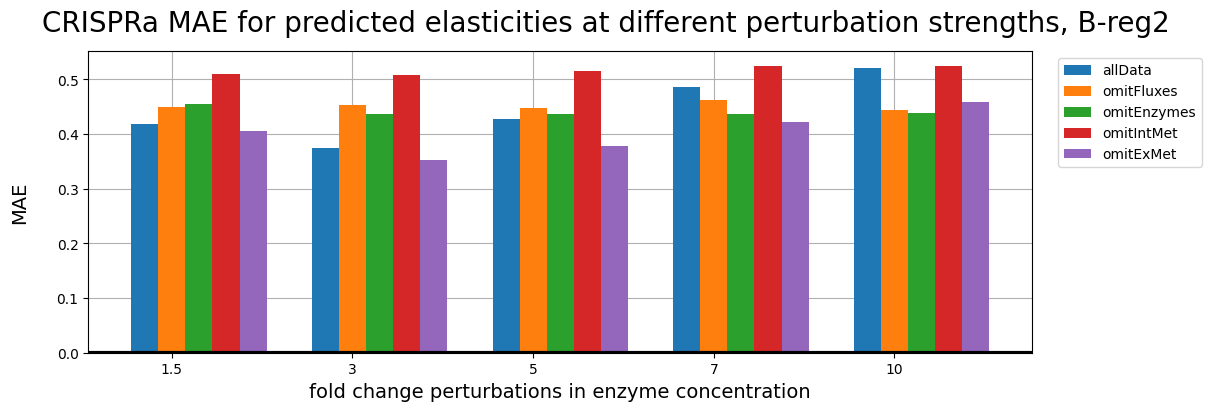

In [22]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((reg2_df[reg2_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((reg2_df[reg2_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((reg2_df[reg2_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((reg2_df[reg2_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((reg2_df[reg2_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, B-reg2", size=20)


## Comparing Spearman r coefficients pairwise to find significant differences

In [23]:
def plot_CI_comparisons(subplot, omitted_type, reg_level, CRISPRi=True, color='orange'):

    if CRISPRi: 
        df1 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']=='allData')][0:5]
        df2 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']==f'omit{omitted_type}')][0:5]

        x1 = np.linspace(90,50,5)
        x2 = np.linspace(90,50,5)

    else:
        df1 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']=='allData')][5:10]
        df2 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']==f'omit{omitted_type}')][5:10]

        x1 = df1['perturbation']
        x2 = df2['perturbation']

    ymin1 = (df1['r'] - df1['lower']).values
    ymax1 = (df1['upper'] - df1['r']).values

    ymin2 = (df2['r'] - df2['lower']).values
    ymax2 = (df2['upper'] - df2['r']).values

    subplot.scatter(x1, 
                abs(df1['r']), alpha=0.8, s=40, zorder=1000, label='all data', 
                color='red')
    subplot.errorbar(x1, df1['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None', color='red', zorder=100)

    subplot.scatter(x2, 
                abs(df2['r']), alpha=0.8, s=100, zorder=50, 
                label=f'omit {omitted_type}', c=color)
    subplot.errorbar(x2, df2['r'], yerr=np.stack((ymin2, ymax2)), 
                 elinewidth=6, linestyle='None', c=color, zorder=10,
                 alpha=0.8)

    subplot.grid(True, which='both', axis='both', zorder=0)
    subplot.set_ylim([0,1])
        

Text(0.5, 0.98, 'TopologyB--Comparing CRISPRi datasets with omitted data at different regulation levels')

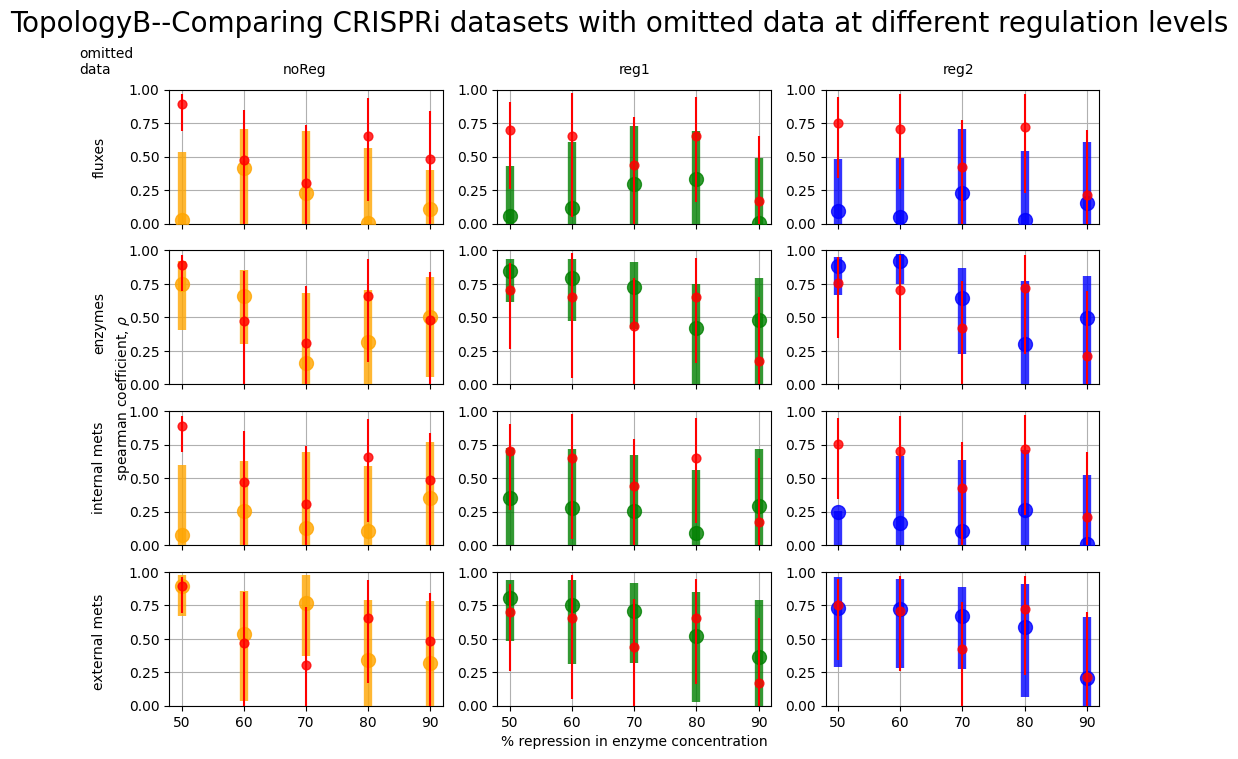

In [24]:
fig, ax = plt.subplots(4, 3, figsize=(12,8), sharex=True)
plot_CI_comparisons(ax[0,0], "Fluxes", "noReg")
plot_CI_comparisons(ax[0,1], "Fluxes", "reg1", color='green')
plot_CI_comparisons(ax[0,2], "Fluxes", "reg2", color='blue')

plot_CI_comparisons(ax[1,0], "Enzymes", "noReg")
plot_CI_comparisons(ax[1,1], "Enzymes", "reg1", color='green')
plot_CI_comparisons(ax[1,2], "Enzymes", "reg2", color='blue')

plot_CI_comparisons(ax[2,0], "IntMet", "noReg")
plot_CI_comparisons(ax[2,1], "IntMet", "reg1", color='green')
plot_CI_comparisons(ax[2,2], "IntMet", "reg2", color='blue')

plot_CI_comparisons(ax[3,0], "ExMet", "noReg")
plot_CI_comparisons(ax[3,1], "ExMet", "reg1", color='green')
plot_CI_comparisons(ax[3,2], "ExMet", "reg2", color='blue')

fig.text(0.05, 0.9, 'omitted\ndata')
fig.text(0.22, 0.9, 'noReg')
fig.text(0.5, 0.9, 'reg1')
fig.text(0.77, 0.9, 'reg2')

fig.text(0.07, 0.77, 'fluxes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.55, 'enzymes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.35, 'internal mets', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.13, 'external mets', rotation=90, rotation_mode='anchor')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration")
plt.ylabel(r"spearman coefficient, $\rho$")

fig.suptitle("TopologyB--Comparing CRISPRi datasets with omitted data at different regulation levels", size=20)


Text(0.5, 0.98, 'TopologyB--Comparing CRISPRa datasets with omitted data at different regulations levels')

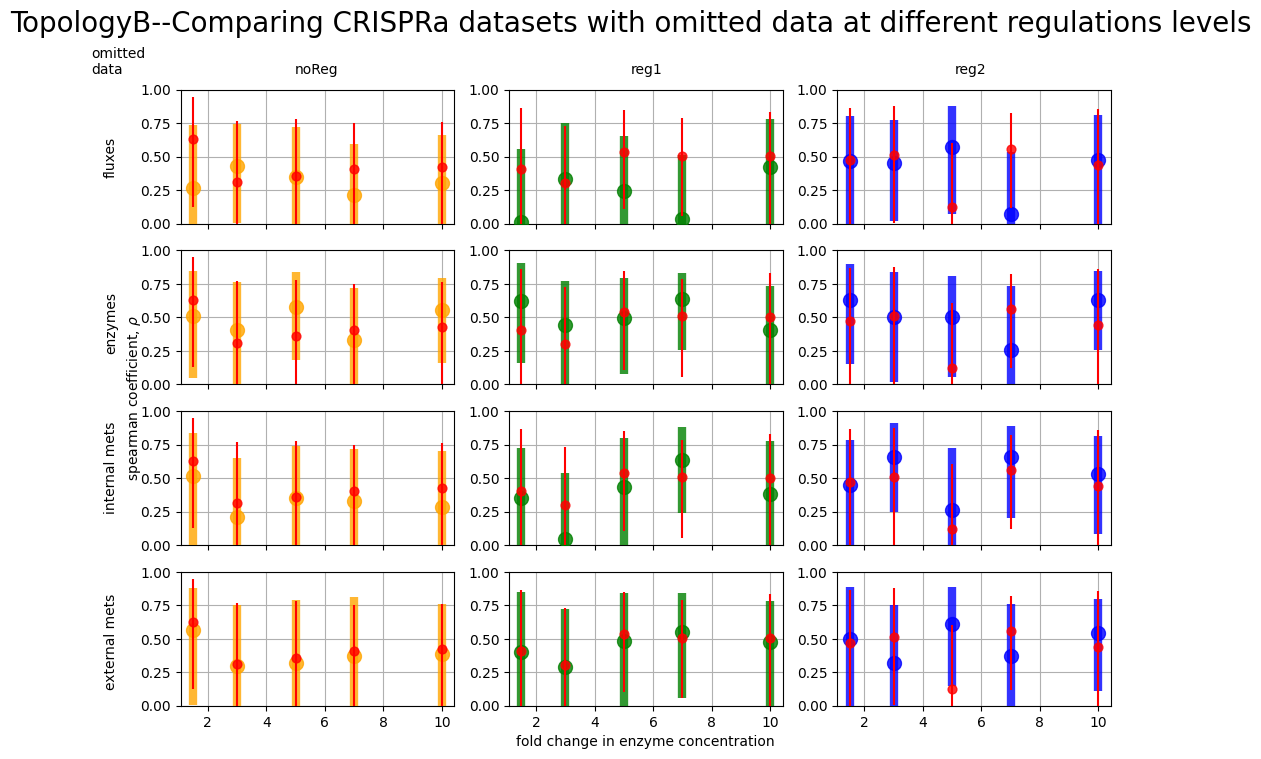

In [25]:
fig, ax = plt.subplots(4, 3, figsize=(12,8), sharex=True)
plot_CI_comparisons(ax[0,0], "Fluxes", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[0,1], "Fluxes", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[0,2], "Fluxes", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[1,0], "Enzymes", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[1,1], "Enzymes", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[1,2], "Enzymes", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[2,0], "IntMet", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[2,1], "IntMet", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[2,2], "IntMet", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[3,0], "ExMet", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[3,1], "ExMet", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[3,2], "ExMet", "reg2", CRISPRi=False, color='blue')


fig.text(0.05, 0.9, 'omitted\ndata')
fig.text(0.22, 0.9, 'noReg')
fig.text(0.5, 0.9, 'reg1')
fig.text(0.77, 0.9, 'reg2')

fig.text(0.07, 0.77, 'fluxes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.55, 'enzymes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.35, 'internal mets', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.13, 'external mets', rotation=90, rotation_mode='anchor')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration")
plt.ylabel(r"spearman coefficient, $\rho$")

fig.suptitle("TopologyB--Comparing CRISPRa datasets with omitted data at different regulations levels", size=20)


## Comprehensive bar plots

In [26]:
B_noReg_df = all_spr_df_B[all_spr_df_B['reg'] == 'noReg']
B_noReg_df['r'] = B_noReg_df['r'].round(3)
B_noReg_df['ymin'] = B_noReg_df['r'] - B_noReg_df['lower']
B_noReg_df['ymax'] = B_noReg_df['upper'] - B_noReg_df['r']

B_reg1_df = all_spr_df_B[all_spr_df_B['reg'] == 'reg1']
B_reg1_df['r'] = B_reg1_df['r'].round(3)
B_reg1_df['ymin'] = B_reg1_df['r'] - B_reg1_df['lower']
B_reg1_df['ymax'] = B_reg1_df['upper'] - B_reg1_df['r']

B_reg2_df = all_spr_df_B[all_spr_df_B['reg'] == 'reg2']
B_reg2_df['r'] = B_reg2_df['r'].round(3)
B_reg2_df['ymin'] = B_reg2_df['r'] - B_reg2_df['lower']
B_reg2_df['ymax'] = B_reg2_df['upper'] - B_reg2_df['r']

C:\Users\user\AppData\Local\Temp\ipykernel_10300\1569309390.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_10300\1569309390.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_10300\1569309390.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, B-noReg')

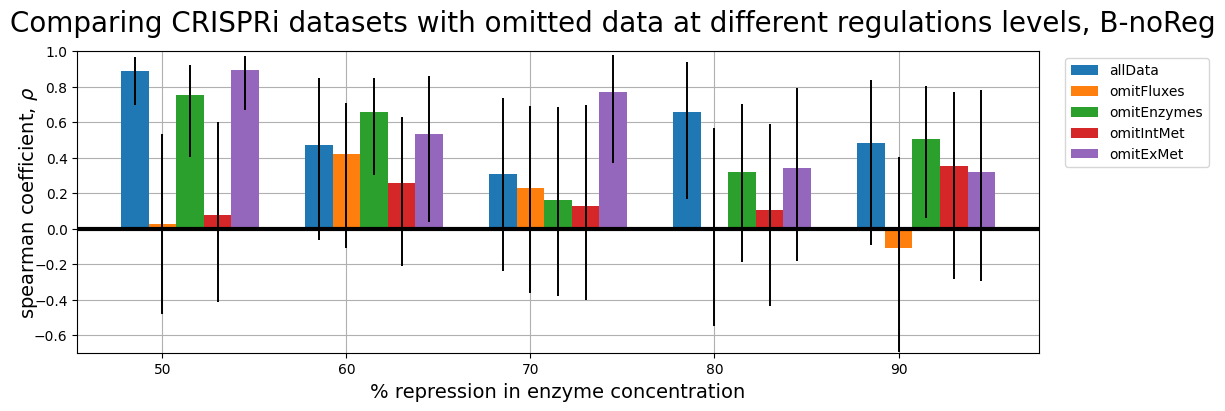

In [27]:
species = list(B_noReg_df['perturbation'].unique()[0:5])[::-1]

# these are the r values for CRISPRi, but in reverse order
penguin_means = {
    'allData': tuple((B_noReg_df[B_noReg_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    ymin = ((B_noReg_df[B_noReg_df['omit'] == attribute]['ymin']).values[0:5])[::-1]
    ymax = ((B_noReg_df[B_noReg_df['omit'] == attribute]['ymax']).values[0:5])[::-1]
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
# plt.ylim((0,1))
plt.ylim((-0.7,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-noReg", size=20)


Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, B-noReg')

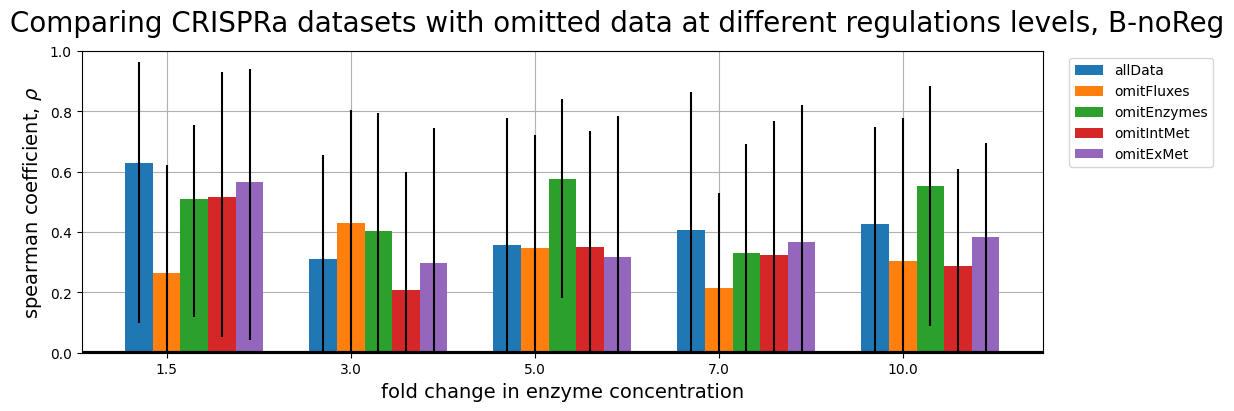

In [28]:
species = B_noReg_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_noReg_df[B_noReg_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitExMet']['r']).values[5:10])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    
    ymin = ((B_noReg_df[B_noReg_df['omit'] == attribute]['ymin']).values[5:10])[::-1]
    ymax = ((B_noReg_df[B_noReg_df['omit'] == attribute]['ymax']).values[5:10])[::-1]
    
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-noReg", size=20)


Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg1')

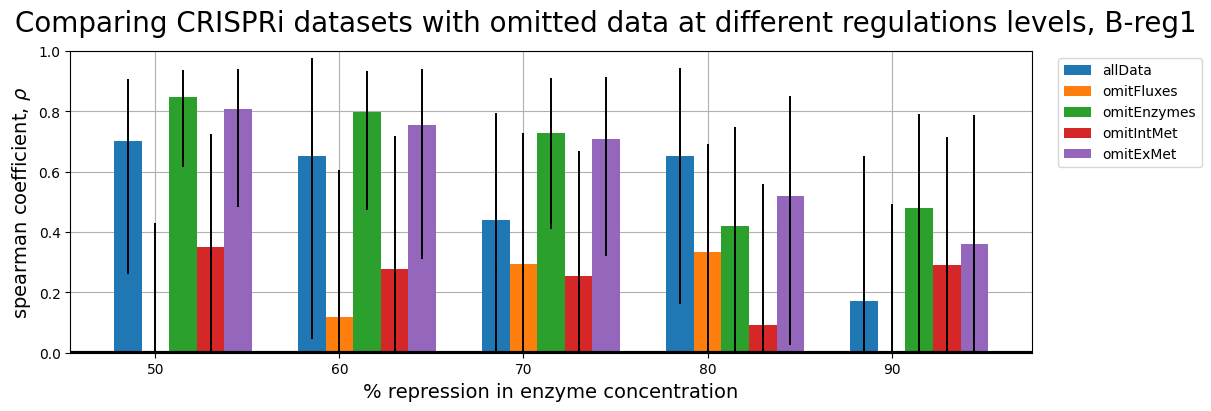

In [30]:
species = list(B_reg1_df['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((B_reg1_df[B_reg1_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier

    ymin = ((B_reg1_df[B_reg1_df['omit'] == attribute]['ymin']).values[0:5])[::-1]
    ymax = ((B_reg1_df[B_reg1_df['omit'] == attribute]['ymax']).values[0:5])[::-1]

    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg1", size=20)


Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg1')

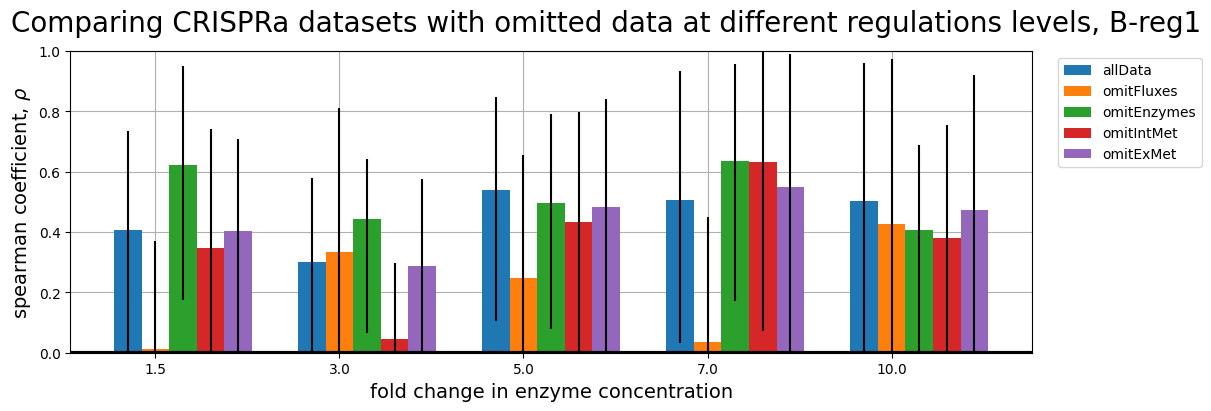

In [31]:
species = B_reg1_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_reg1_df[B_reg1_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitExMet']['r']).values[5:10])
}


x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier

    ymin = ((B_reg1_df[B_reg1_df['omit'] == attribute]['ymin']).values[5:10])[::-1]
    ymax = ((B_reg1_df[B_reg1_df['omit'] == attribute]['ymax']).values[5:10])[::-1]

    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg1", size=20)


Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg2')

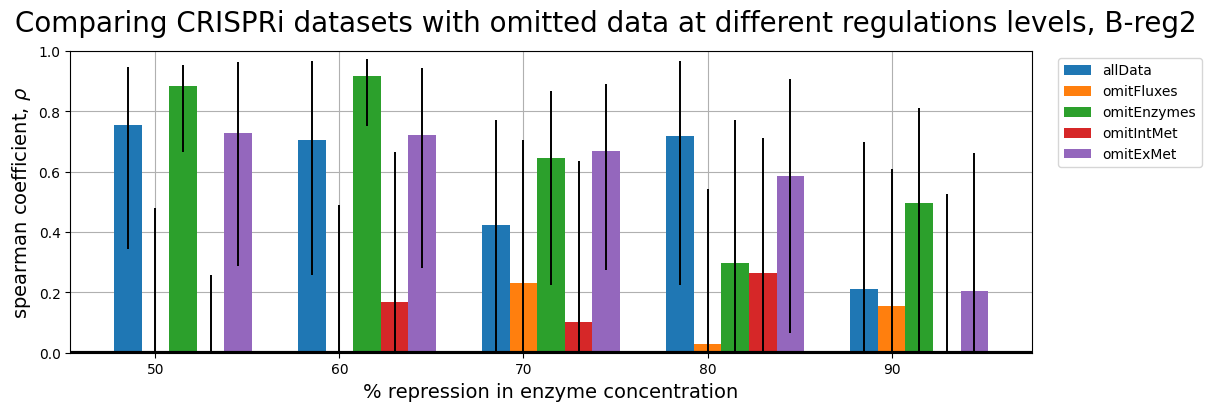

In [32]:
species = list(B_reg2_df['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((B_reg2_df[B_reg2_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier

    ymin = ((B_reg2_df[B_reg2_df['omit'] == attribute]['ymin']).values[0:5])[::-1]
    ymax = ((B_reg2_df[B_reg2_df['omit'] == attribute]['ymax']).values[0:5])[::-1]

    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg2", size=20)


Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg2')

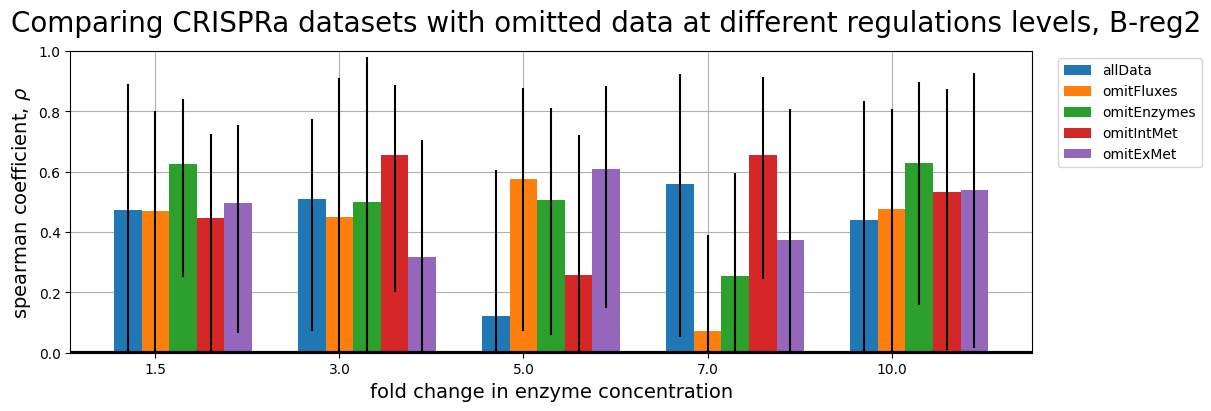

In [33]:
species = B_reg2_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_reg2_df[B_reg2_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitExMet']['r']).values[5:10])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier

    ymin = ((B_reg2_df[B_reg2_df['omit'] == attribute]['ymin']).values[5:10])[::-1]
    ymax = ((B_reg2_df[B_reg2_df['omit'] == attribute]['ymax']).values[5:10])[::-1]

    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg2", size=20)


## Make tables of ranking correctness

In [34]:
os.chdir('../data/results/rankings/')

In [35]:
rank_file_list = [i for i in os.listdir() if "topologyB" in i]

rank_dfs = []
for file in rank_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    rank_dfs.append(a)

all_rank_df_B = pd.concat(rank_dfs)# .drop('1.01x', axis=1)
all_rank_df_B

,v19,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x,reg,omit
0,1.0,v18,v18,v1,v18,v18,v1,v1,v18,v4,v4,v4,noReg,allData
1,2.0,v1,v14,v18,v14,v14,v18,v3,v1,v5,v5,v5,noReg,allData
2,3.0,v14,v1,v14,v1,v1,v14,v2,v15,v1,v1,v7,noReg,allData
3,4.0,v7,v7,v2,v15,v2,v7,v7,v2,v6,v7,v1,noReg,allData
4,5.0,v4,v15,v7,v8,v7,v3,v18,v4,v9,v9,v9,noReg,allData
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,15.0,v15,v5,v12,v2,v9,v16,v14,v16,v10,v3,v8,reg2,omitIntMet
15,16.0,v16,v3,v5,v3,v3,v18,v16,v2,v1,v2,v13,reg2,omitIntMet
16,17.0,v2,v6,v15,v6,v14,v7,v3,v17,v3,v16,v16,reg2,omitIntMet
17,18.0,v17,v10,v6,v10,v2,v12,v2,v3,v2,v15,v17,reg2,omitIntMet


In [36]:
os.chdir('../../../notebooks/')

#### Counts of top three ranked FCCs

In [86]:
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x', '0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [87]:
topThree_df = all_rank_df_B[all_rank_df_B['v19'].isin([1, 2, 3])]

gt_ranks = all_rank_df_B['gt'].head(19)

rank_noReg = topThree_df[topThree_df['reg']=='noReg']#.drop('gt', axis=1)
rank_reg1 = topThree_df[topThree_df['reg']=='reg1']#.drop('gt', axis=1)
rank_reg2 = topThree_df[topThree_df['reg']=='reg2']#.drop('gt', axis=1)

In [88]:
rank_noReg

,v19,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x,reg,omit
0,1.0,v18,v18,v1,v18,v18,v1,v1,v18,v4,v4,v4,noReg,allData
1,2.0,v1,v14,v18,v14,v14,v18,v3,v1,v5,v5,v5,noReg,allData
2,3.0,v14,v1,v14,v1,v1,v14,v2,v15,v1,v1,v7,noReg,allData
0,1.0,v18,v8,v5,v5,v5,v1,v1,v1,v1,v1,v1,noReg,omitEnzymes
1,2.0,v1,v18,v6,v1,v18,v4,v3,v4,v4,v3,v9,noReg,omitEnzymes
2,3.0,v14,v13,v7,v4,v4,v18,v7,v3,v3,v5,v12,noReg,omitEnzymes
0,1.0,v18,v18,v14,v1,v1,v1,v1,v18,v18,v4,v4,noReg,omitExMet
1,2.0,v1,v14,v18,v18,v3,v18,v3,v15,v15,v1,v5,noReg,omitExMet
2,3.0,v14,v16,v2,v14,v2,v7,v2,v1,v1,v5,v1,noReg,omitExMet
0,1.0,v18,v15,v18,v14,v4,v16,v18,v4,v5,v11,v12,noReg,omitFluxes


In [89]:
gt_t3 = rank_noReg.groupby('omit')['gt'].apply(list).reset_index()
gt_t3_sets = np.where(gt_t3['gt']=='','', gt_t3['gt'].map(set))
gt_t3_sets

t3_sets = []
for pt in pt_labels: 
    t3 = rank_noReg.groupby('omit')[pt].apply(list).reset_index()
    t3_sets.append(np.where(t3[pt]=='','', t3[pt].map(set)))

scores=[]
for i in t3_sets: 
    for ii, gt_t3 in enumerate(gt_t3_sets): 
        scores.append(len(set.intersection(gt_t3, i[ii])))

t3_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t3_results

,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
allData,3,3,3,3,3,1,2,1,1,0
omitEnzymes,1,0,1,1,2,1,1,1,1,1
omitExMet,2,2,3,1,2,1,2,2,1,1
omitFluxes,2,2,2,1,1,2,1,0,0,0
omitIntMet,2,1,1,1,2,1,1,1,0,0


In [90]:
gt_t3 = rank_reg1.groupby('omit')['gt'].apply(list).reset_index()
gt_t3_sets = np.where(gt_t3['gt']=='','', gt_t3['gt'].map(set))
gt_t3_sets

t3_sets = []
for pt in pt_labels: 
    t3 = rank_reg1.groupby('omit')[pt].apply(list).reset_index()
    t3_sets.append(np.where(t3[pt]=='','', t3[pt].map(set)))

scores=[]
for i in t3_sets: 
    for ii, gt_t3 in enumerate(gt_t3_sets): 
        scores.append(len(set.intersection(gt_t3, i[ii])))

t3_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t3_results

,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
allData,1,2,2,2,2,1,2,1,0,1
omitEnzymes,1,0,1,1,3,2,2,0,2,1
omitExMet,2,2,2,2,2,1,2,2,2,1
omitFluxes,1,2,1,1,0,1,1,2,1,1
omitIntMet,1,1,1,1,1,1,1,1,2,1


In [91]:
gt_t3 = rank_reg2.groupby('omit')['gt'].apply(list).reset_index()
gt_t3_sets = np.where(gt_t3['gt']=='','', gt_t3['gt'].map(set))
gt_t3_sets

t3_sets = []
for pt in pt_labels: 
    t3 = rank_reg2.groupby('omit')[pt].apply(list).reset_index()
    t3_sets.append(np.where(t3[pt]=='','', t3[pt].map(set)))

scores=[]
for i in t3_sets: 
    for ii, gt_t3 in enumerate(gt_t3_sets): 
        scores.append(len(set.intersection(gt_t3, i[ii])))

t3_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t3_results

,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
allData,1,2,2,2,2,1,2,1,1,1
omitEnzymes,1,0,1,2,2,2,2,2,1,1
omitExMet,1,2,2,2,2,1,2,3,3,1
omitFluxes,1,1,1,1,0,0,1,2,1,1
omitIntMet,1,2,1,1,0,2,1,2,1,2


In [ ]:
# visualizations. Heatmaps?

#### Counts of top five ranked FCCs

In [92]:
topFive_df = all_rank_df_B[all_rank_df_B['v19'].isin([1, 2, 3, 4, 5])]

gt_ranks_5 = all_rank_df_B['gt'].head(19)

rank_noReg_5 = topFive_df[topFive_df['reg']=='noReg']#.drop('gt', axis=1)
rank_reg1_5 = topFive_df[topFive_df['reg']=='reg1']#.drop('gt', axis=1)
rank_reg2_5 = topFive_df[topFive_df['reg']=='reg2']#.drop('gt', axis=1)

In [93]:
gt_t5 = rank_noReg_5.groupby('omit')['gt'].apply(list).reset_index()
gt_t5_sets = np.where(gt_t5['gt']=='','', gt_t5['gt'].map(set))
gt_t5_sets

t5_sets = []
for pt in pt_labels: 
    t5 = rank_noReg_5.groupby('omit')[pt].apply(list).reset_index()
    t5_sets.append(np.where(t5[pt]=='','', t5[pt].map(set)))

scores=[]
for i in t5_sets: 
    for ii, gt_t5 in enumerate(gt_t5_sets): 
        scores.append(len(set.intersection(gt_t5, i[ii])))

t5_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t5_results

,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
allData,4,4,3,4,4,3,3,2,3,3
omitEnzymes,3,2,2,2,3,2,3,3,1,2
omitExMet,3,2,5,3,4,2,3,3,2,3
omitFluxes,2,2,2,2,2,2,2,2,1,1
omitIntMet,4,2,3,2,2,3,3,2,1,1


In [94]:
gt_t5 = rank_reg1_5.groupby('omit')['gt'].apply(list).reset_index()
gt_t5_sets = np.where(gt_t5['gt']=='','', gt_t5['gt'].map(set))
gt_t5_sets

t5_sets = []
for pt in pt_labels: 
    t5 = rank_reg1_5.groupby('omit')[pt].apply(list).reset_index()
    t5_sets.append(np.where(t5[pt]=='','', t5[pt].map(set)))

scores=[]
for i in t5_sets: 
    for ii, gt_t5 in enumerate(gt_t5_sets): 
        scores.append(len(set.intersection(gt_t5, i[ii])))

t5_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t5_results

,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
allData,3,4,3,4,4,3,3,2,3,3
omitEnzymes,2,2,4,3,3,3,3,2,3,1
omitExMet,3,3,4,4,4,3,2,4,3,3
omitFluxes,2,3,3,2,2,1,2,4,1,2
omitIntMet,2,2,2,2,2,3,2,2,4,3


In [95]:
gt_t5 = rank_reg2_5.groupby('omit')['gt'].apply(list).reset_index()
gt_t5_sets = np.where(gt_t5['gt']=='','', gt_t5['gt'].map(set))
gt_t5_sets

t5_sets = []
for pt in pt_labels: 
    t5 = rank_reg2_5.groupby('omit')[pt].apply(list).reset_index()
    t5_sets.append(np.where(t5[pt]=='','', t5[pt].map(set)))

scores=[]
for i in t5_sets: 
    for ii, gt_t5 in enumerate(gt_t5_sets): 
        scores.append(len(set.intersection(gt_t5, i[ii])))

t5_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t5_results

,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
allData,3,4,3,4,4,3,3,2,3,3
omitEnzymes,3,3,4,4,3,2,3,3,1,3
omitExMet,3,3,4,3,3,3,2,4,3,3
omitFluxes,2,2,3,2,2,2,2,4,1,1
omitIntMet,2,3,2,3,2,3,3,3,4,2
